In [ ]:
!unzip hw5.zip

In [75]:
import numpy as np
import os
import glob
from sklearn.cluster import KMeans

def build_vocabulary(image_paths, vocab_size):
    """ Sample SIFT descriptors, cluster them using k-means, and return the fitted k-means model.
    NOTE: We don't necessarily need to use the entire training dataset. You can use the function
    sample_images() to sample a subset of images, and pass them into this function.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    vocab_size: the number of clusters desired.

    Returns
    -------
    kmeans: the fitted k-means clustering model.
    """
    n_image = len(image_paths)

    # Since want to sample tens of thousands of SIFT descriptors from different images, we
    # calculate the number of SIFT descriptors we need to sample from each image.
    n_each = int(np.ceil(10000 / n_image))

    # Initialize an array of features, which will store the sampled descriptors
    # keypoints = np.zeros((n_image * n_each, 2))
    descriptors = np.zeros((n_image * n_each, 128))

    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)
        sift_keypoints = features[:, :2]
        sift_descriptors = features[:, 2:]

        # TODO: Randomly sample n_each descriptors from sift_descriptor and store them into descriptors
        # generate some random indices of size n_each
        indices = np.random.randint(0, sift_descriptors.shape[0] - 1, size=n_each, dtype=int)
        # select some random sift descriptors by the indices just generated
        for j, index in enumerate(indices):
            descriptors[i * n_each + j] = sift_descriptors[index]

    # TODO: pefrom k-means clustering to cluster sampled sift descriptors into vocab_size regions.
    # You can use KMeans from sci-kit learn.
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    # generate the vocabulary by the descriptors selected
    # random state of 42 is a typical value from the doc
    kmeans = KMeans(n_clusters=vocab_size, random_state=42).fit(descriptors)

    return kmeans

def get_bags_of_sifts(image_paths, kmeans):
    """ Represent each image as bags of SIFT features histogram.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    kmeans: k-means clustering model with vocab_size centroids.

    Returns
    -------
    image_feats: an (n_image, vocab_size) matrix, where each row is a histogram.
    """
    n_image = len(image_paths)
    vocab_size = kmeans.cluster_centers_.shape[0]

    image_feats = np.zeros((n_image, vocab_size))

    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)

        # TODO: Assign each feature to the closest cluster center
        # Again, each feature consists of the (x, y) location and the 128-dimensional sift descriptor
        # You can access the sift descriptors part by features[:, 2:]
        sift_descriptors = features[:, 2:]
        # group the descriptors into vocabs
        sift_vocab_indices = kmeans.predict(sift_descriptors)

        # TODO: Build a histogram normalized by the number of descriptors
        num_descriptors = sift_descriptors.shape[0]
        # count the number of descriptors per vocab
        raw_histogram = np.bincount(sift_vocab_indices, minlength=vocab_size)
        # normalize the histogram by the number of descriptors which is to prevent
        # the bag of feature magnitude from being greatly influenced by the image size
        normalized_histogram = raw_histogram / num_descriptors
        image_feats[i] = normalized_histogram

    return image_feats

def load(ds_path):
    """ Load from the training/testing dataset.

    Parameters
    ----------
    ds_path: path to the training/testing dataset.
             e.g., sift/train or sift/test

    Returns
    -------
    image_paths: a (n_sample, 1) array that contains the paths to the descriptors.
    labels: class labels corresponding to each image
    """
    # Grab a list of paths that matches the pathname
    files = glob.glob(os.path.join(ds_path, "*", "*.txt"))
    n_files = len(files)
    image_paths = np.asarray(files)

    # Get class labels
    classes = glob.glob(os.path.join(ds_path, "*"))
    labels = np.zeros(n_files)

    for i, path in enumerate(image_paths):
        folder, fn = os.path.split(path)
        labels[i] = np.argwhere(np.core.defchararray.equal(classes, folder))[0,0]

    # Randomize the order
    idx = np.random.choice(n_files, size=n_files, replace=False)
    image_paths = image_paths[idx]
    labels = labels[idx]

    return image_paths, labels

def save(file, feats):
  file = open(str(file) + ".npy", "wb")
  np.save(file, feats)
  file.close()


if __name__ == "__main__":
    paths, labels = load("sift/train")
    #build_vocabulary(paths, 10)


In [76]:
#Starter code prepared by Borna Ghotbi, Polina Zablotskaia, and Ariel Shann for Computer Vision
#based on a MATLAB code by James Hays and Sam Birch

import numpy as np
from classifiers import nearest_neighbor_classify, svm_classify
from os.path import dirname, basename
import matplotlib.pyplot as plt

#For this assignment, you will need to report performance for sift features on two different classifiers:
# 1) Bag of sift features and nearest neighbor classifier
# 2) Bag of sift features and linear SVM classifier

#For simplicity you can define a "num_train_per_cat" vairable, limiting the number of
#examples per category. num_train_per_cat = 100 for intance.

#Sample images from the training/testing dataset.
#You can limit number of samples by using the n_sample parameter.

print('Getting paths and labels for all train and test data\n')
train_image_paths, train_labels = load("sift/train")
test_image_paths, test_labels = load("sift/test")


''' Step 1: Represent each image with the appropriate feature
 Each function to construct features should return an N x d matrix, where
 N is the number of paths passed to the function and d is the
 dimensionality of each image representation. See the starter code for
 each function for more details. '''

print('Extracting labels\n')
labels = []
# Extract label names
for i in range(15):
    index = np.where(train_labels==i)[0][0]
    labels.append(basename(dirname(train_image_paths[index])))

print('Extracting SIFT features\n')
#TODO: You code build_vocabulary function in util.py
kmeans = build_vocabulary(train_image_paths, vocab_size=100)

#TODO: You code get_bags_of_sifts function in util.py
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)

# save the feats and label
save("train_image", train_image_feats)
save("test_image", test_image_feats)
save("train_label", train_labels)
save("test_label", test_labels)



Getting paths and labels for all train and test data

Extracting labels

Extracting SIFT features



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-77-563d4463c55b>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labeled_feats[i] = labeled_feats[i] / int(label_count[i])


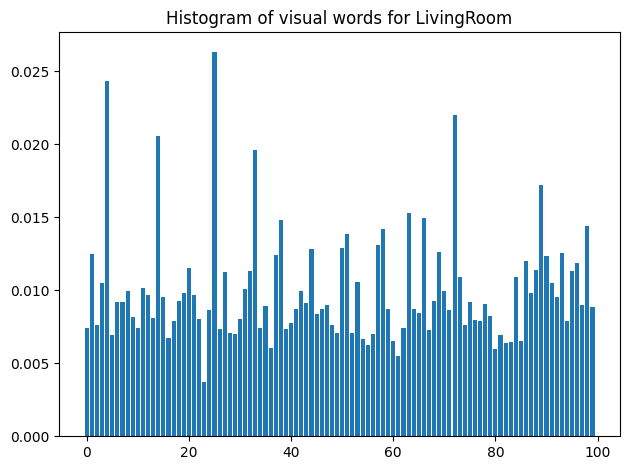

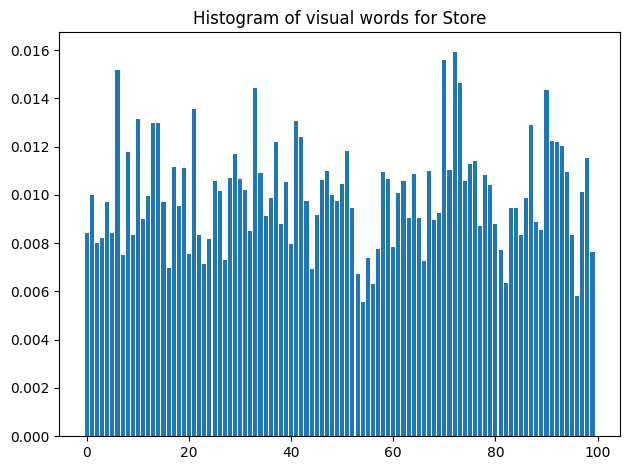

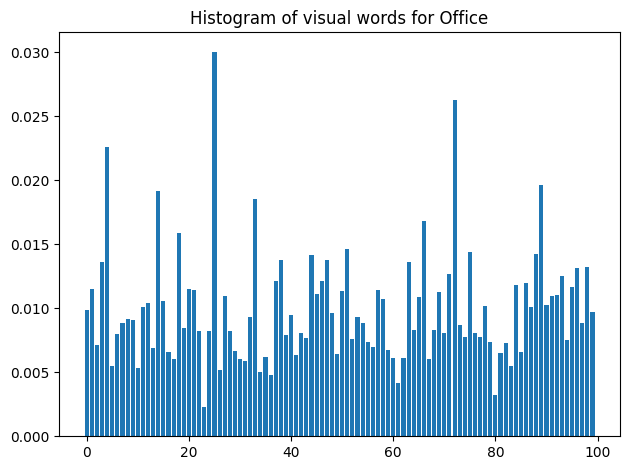

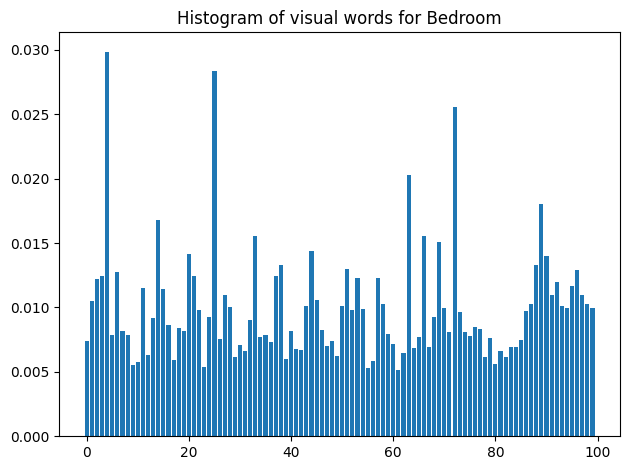

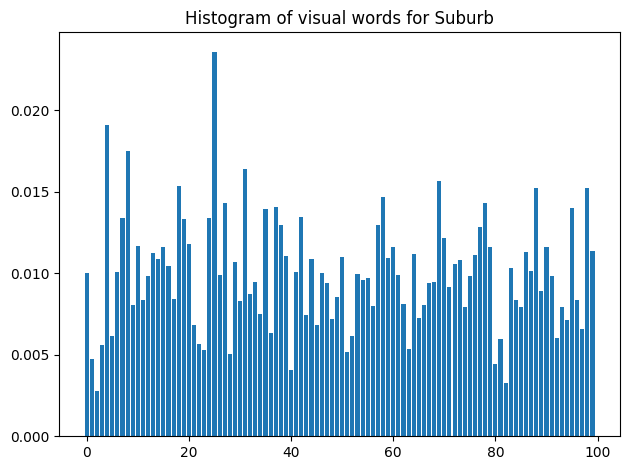

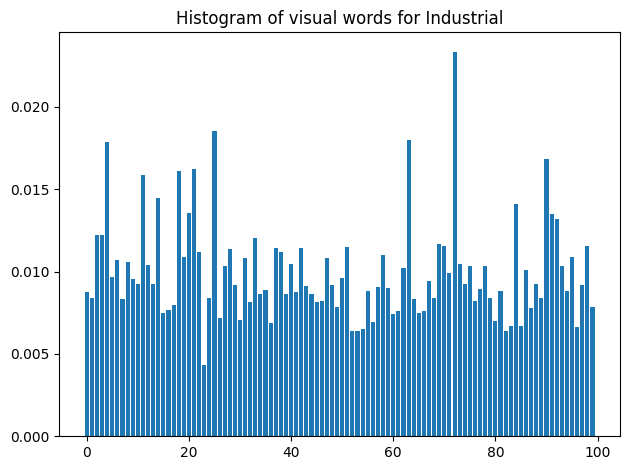

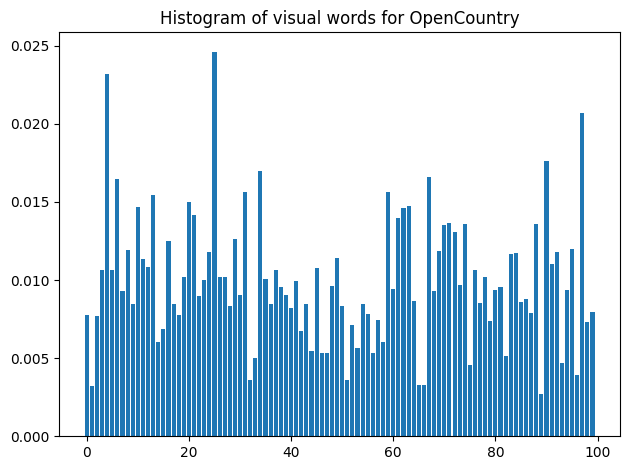

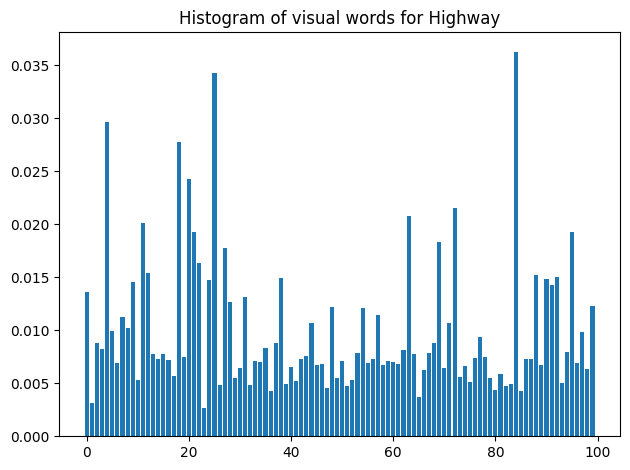

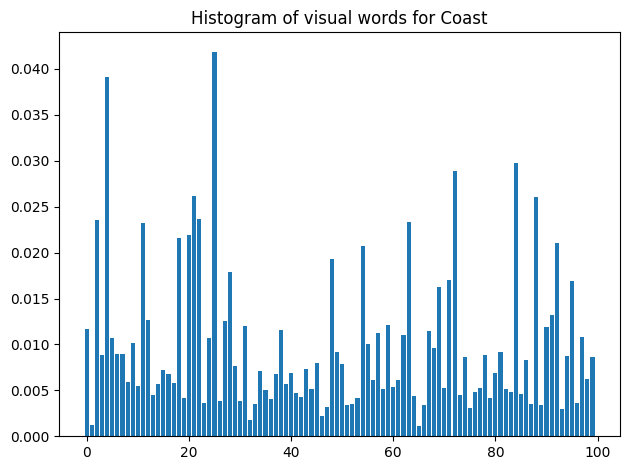

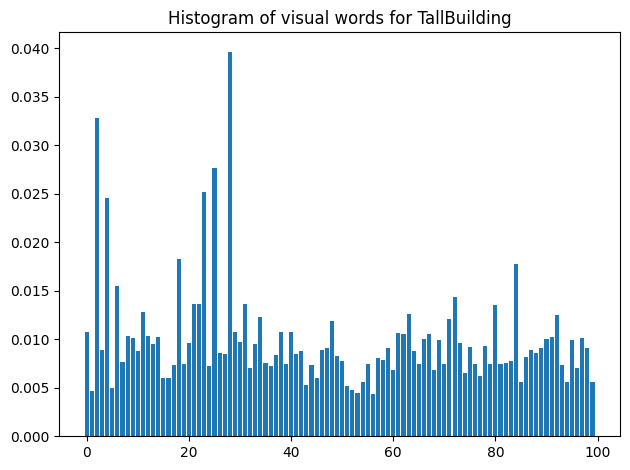

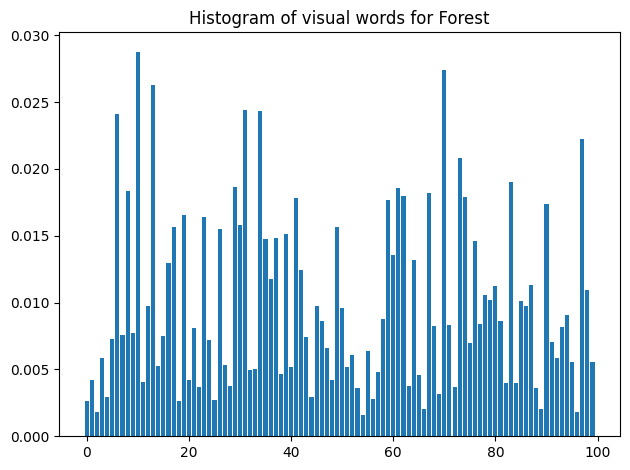

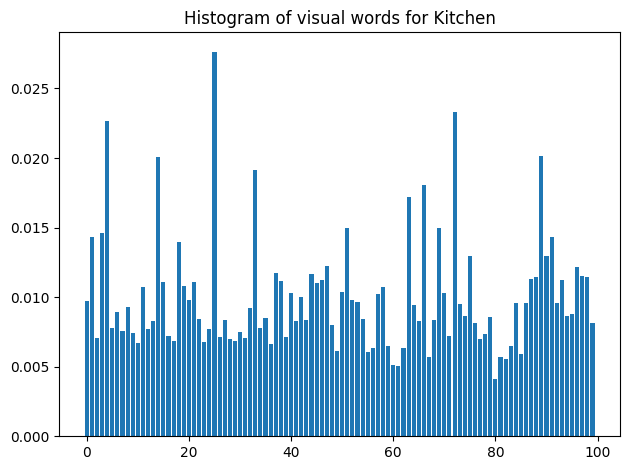

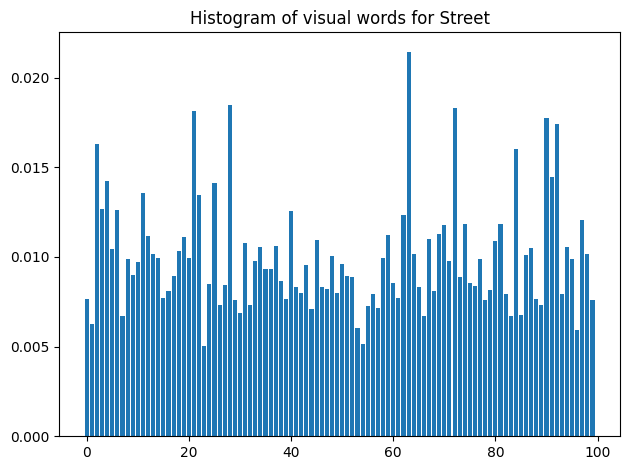

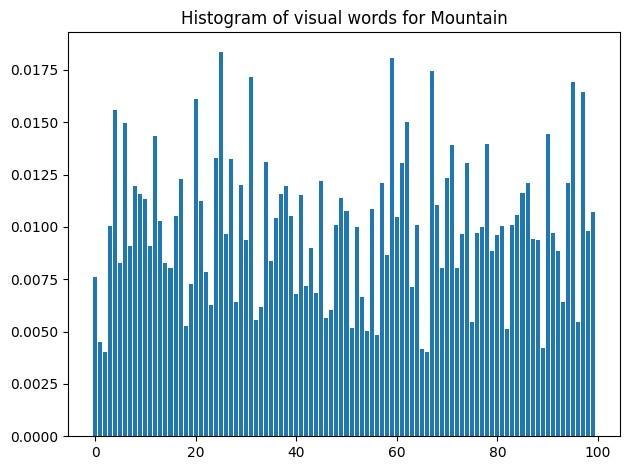

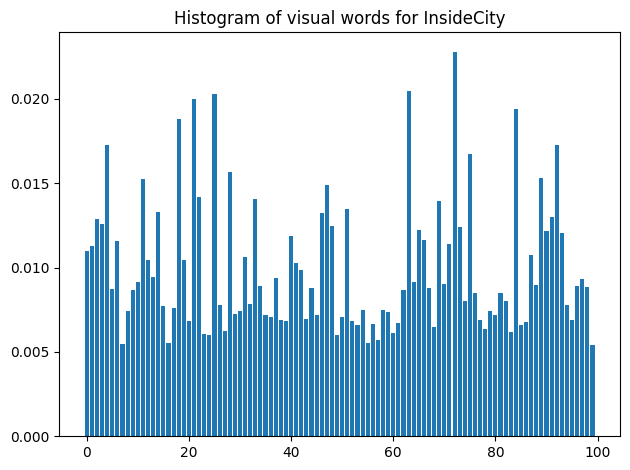

<Figure size 640x480 with 0 Axes>

In [77]:
# Sum up the histograms of all the pictures of the same label
labeled_feats = np.zeros((15,train_image_feats.shape[1]))  # 15x200
# Count the number of images appear for each label
label_count = np.zeros((15,1))
for i in range(train_image_feats.shape[0]):
  labeled_feats[int(train_labels[i])] += train_image_feats[i]
  label_count[int(train_labels[i])] = label_count[int(train_labels[i])] + 1

# Average the histograms by the number of images
for i in range(15):
  labeled_feats[i] = labeled_feats[i] / int(label_count[i])

# plot the histograms
for i in range(15):
  plt.bar(range(train_image_feats.shape[1]), labeled_feats[i])
  plt.title("Histogram of visual words for " + labels[i])
  plt.tight_layout()
  plt.show()
  plt.clf()



*   Industrial   
The average of the histogram is around 0.010 while there are a few outliers that go beyond 0.015 and even one goes beyond 0.020
*   Bedroom     
The average of the histogram is around 0.010 but there are outliers that exceed 0.025
*   Highway       
The average is sround 0.010 but the variance is faily big. The largest value is over 0.035
*   Street     
The average is around 0.010. One outlier is over 0.025
*   Kitchen         
The average is around 0.010 but variance is big. A few outliers that are between 0.020 and 0.025
*   TallBuilding         
The average is around 1.0 but variance is big. The largest value is nearly 0.040 while a few others over 0.025
*   Coast         
The average is hard to tell because the variance is very big. A few of them is over 0.040
*   Office      
Variance is very big. Largest values between 0.020 and 0.030
*   Mountain       
The largest value is not too large which is just over 0.020 but variance is big
*   Store       
Variance is small. All the values squeeze between 0.016 and 0.006
*   Suburb      
Variance is big but the largest value is not very large. Compared to Mountain, the largest value appears at the last a few features and the middle ones while Mountain has some big values at the first and the middle.
*   OpenCountry           
Variance is big but the largest value is not very large.
*   Forest            
Varience is pretty big. The largest value is around 0.025 while the smallest value is almost 0.010.
*   InsideCity     
Average should be lower than 0.010. Variance is not big.
*   LivingRoom     
The average of the histogram is around 0.010 but there are outliers that exceed 0.025

     
By looking at the histograms, I would say, Kitchen and LivingRoom would be the hardest to seperate.

In [85]:
 #Starter code prepared by Borna Ghotbi for computer vision
 #based on MATLAB code by James Hay

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

'''This function will predict the category for every test image by finding
the training image with most similar features. Instead of 1 nearest
neighbor, you can vote based on k nearest neighbors which will increase
performance (although you need to pick a reasonable value for k). '''

def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.

    Returns
        -------
    	is an M x l cell array, where each row is a one-hot vector
        indicating the predicted category for each test image.

    Usefull funtion:

    	# You can use knn from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    '''
    # load the model
    model = KNeighborsClassifier(n_neighbors=7)
    # train the model
    model.fit(train_image_feats, train_labels.astype('int'))
    # predict the labels
    predicted_labels = model.predict(test_image_feats)
    return predicted_labels, model



'''This function will train a linear SVM for every category (i.e. one vs all)
and then use the learned linear classifiers to predict the category of
very test image. Every test feature will be evaluated with all 15 SVMs
and the most confident SVM will "win". Confidence, or distance from the
margin, is W*X + B where '*' is the inner product or dot product and W and
B are the learned hyperplane parameters. '''

def svm_classify(train_image_feats, train_labels, test_image_feats):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.

    Returns
        -------
    	is an M x l cell array, where each row is a one-hot vector
        indicating the predicted category for each test image.

    Usefull funtion:

    	# You can use svm from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/svm.html

    '''
    # load the model
    svm_model = svm.LinearSVC(C=13)
    # train the model
    svm_model.fit(train_image_feats, train_labels)
    # predict the labels
    predicted_labels = svm_model.predict(test_image_feats)
    return predicted_labels



Using nearest neighbor classifier to predict test set categories

---Evaluation---

knn accuracy: 37.111111111111114


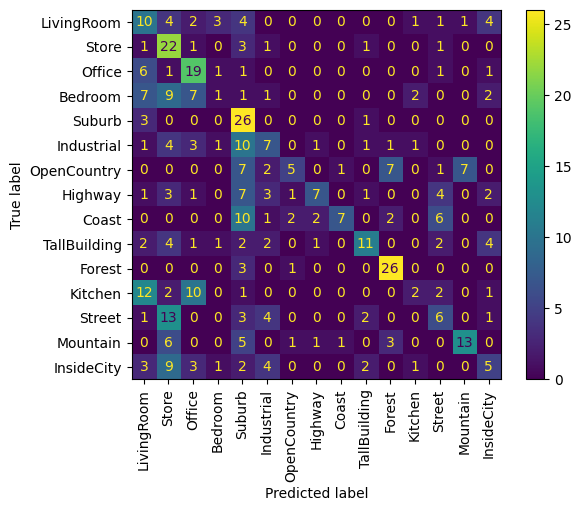

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

''' Step 2: Classify each test image by training and using the appropriate classifier
 Each function to classify test features will return an N x l cell array,
 where N is the number of test cases and each entry is a string indicating
 the predicted one-hot vector for each test image. See the starter code for each function
 for more details. '''

print('Using nearest neighbor classifier to predict test set categories\n')
#TODO: YOU CODE nearest_neighbor_classify function from classifers.py
pred_labels_knn, knn_model = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)


print('---Evaluation---\n')
# Step 3: Build a confusion matrix and score the recognition system for
#         each of the classifiers.
# TODO: In this step you will be doing evaluation.
# 1) Calculate the total accuracy of your model by counting number
#   of true positives and true negatives over all.
# 2) Build a Confusion matrix and visualize it.
#   You will need to convert the one-hot format labels back
#   to their category name format.
# calculate the accuracy by sklearn metrics
knn_acc = accuracy_score(test_labels, pred_labels_knn) * 100.0
print("knn accuracy: " + str(knn_acc))
# display the confusion matrix
disp_knn = ConfusionMatrixDisplay.from_predictions(test_labels, pred_labels_knn, display_labels=labels, xticks_rotation="vertical")
plt.show()
# Interpreting your performance with 100 training examples per category:
#  accuracy  =   0 -> Your code is broken (probably not the classifier's
#                     fault! A classifier would have to be amazing to
#                     perform this badly).
#  accuracy ~= .10 -> Your performance is chance. Something is broken or
#                     you ran the starter code unchanged.
#  accuracy ~= .40 -> Rough performance with bag of SIFT and nearest
#                     neighbor classifier.
#  accuracy ~= .50 -> You've gotten things roughly correct with bag of
#                     SIFT and a linear SVM classifier.
#  accuracy >= .60 -> You've added in spatial information somehow or you've
#                     added additional, complementary image features. This
#                     represents state of the art in Lazebnik et al 2006.
#  accuracy >= .85 -> You've done extremely well. This is the state of the
#                     art in the 2010 SUN database paper from fusing many
#                     features. Don't trust this number unless you actually
#                     measure many random splits.
#  accuracy >= .90 -> You used modern deep features trained on much larger
#                     image databases.
#  accuracy >= .96 -> You can beat a human at this task. This isn't a
#                     realistic number. Some accuracy calculation is broken
#                     or your classifier is cheating and seeing the test
#                     labels.


By experimenting with the size of k, I found out that accuracy peaked when k was equal to 7. No matter when k increases or decreaes, the accuracy becomes smaller.

Using support vector machine to predict test set categories

svm accuracy: 48.22222222222222


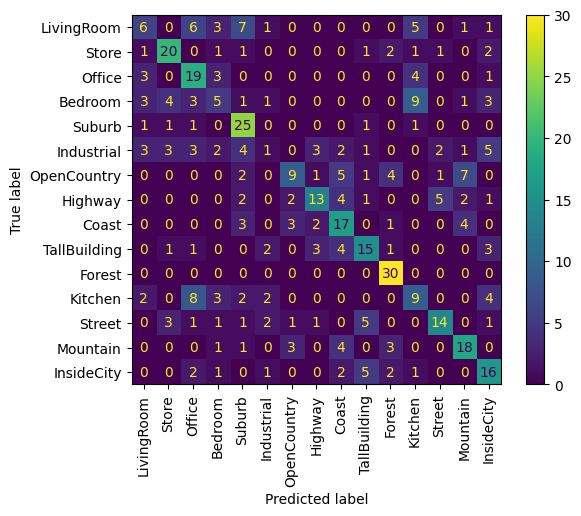

In [86]:
print('Using support vector machine to predict test set categories\n')
#TODO: YOU CODE svm_classify function from classifers.py
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats)
# caclulate the accuracy
svm_acc = accuracy_score(test_labels, pred_labels_svm) * 100.0
print("svm accuracy: " + str(svm_acc))
# display the confusion matrix
disp_svm = ConfusionMatrixDisplay.from_predictions(test_labels, pred_labels_svm, display_labels=labels, xticks_rotation="vertical")
plt.show()

By experimenting different values of C, 13 is the optimized value for the accuracy to be maximized. Ranging from 10 ti 15, C is a value to have a pretty good accuracy with something over 48%.

                        | accuracy    |    k/C value
    optimized knn model | 37.11%      |    7
    optimized svm model | 48.22%      |    13